F2O's Philosophy
----------------


To allow a high level, almost *algorithmic description-like*, way to  
program first order optimization methods. In the praxis, this idea
is implemented by automatically assigning *function pointers* to 
variables (i.e. Python names) which are then used in the actual code.


Illustrative example
--------------------


Quadratic problem via GD (gradient descent)
===========================================


Consider the quadratic cost functional

.. math::
   :nowrap:

   \begin{eqnarray}
     F(\mathbf{x}) & = & 0.5\| \mbox{Op}(\mathbf{x}) - \mathbf{b} \|_2^2 \qquad (1) 
   \end{eqnarray}

where

* :math:`\nabla F` is :math:`L`-Lipschitz continuous: :math:`\| \nabla F(\mathbf{x}) - \nabla F(\mathbf{y}) \|_2 \leq L(F)\| \mathbf{x} - \mathbf{y} \|_2`, 
* :math:`\mathbf{x} \in \mathbb{R}^N`,
* :math:`\mbox{Op}(\mathbf{x}) : \mathbb{R}^N \mapsto \mathbb{R}^L` represents a forward operator,
* :math:`\mathbf{b} \in \mathbb{R}^L` represents the observed data.


## GD (gradient descent) 
The GD algorithm can be used to find the minimizer of $F(\mathbf{x})$. A simple description of GD is summarized next:

$ 
\begin{array}{l}
\begin{array}{rcl}
\mbox{Init :} & & \mathbf{x}_0  - \mbox{ Initial solution}\\
 & & p_\alpha - \mbox{ Compute step-size (simplest case: } \alpha = \mbox{cte.)}\\
 & \\
\end{array} \\
\mathbf{\mbox{for }} k = 0,1,\ldots \\
 \quad \mathbf{g}_k = \nabla F(\mathbf{x}_k) \\
 \quad \alpha_k = p_\alpha(\cdot) \\
 \quad \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k\cdot \mathbf{g}_k
\end{array} 
$

### The (simplified) F2O code that implements GD is shown below

```python

def gd(Op, b, nIter, args):

    computeCost, computeGrad, computeSS = SetFunctions(Op, args)

    for k in range(nIter):
        
      grad = computeGrad(x, b, None)
                        
      alpha, grad = computeSS(k, grad, x)         # compute step-size; if needed, correct grad           
    
      x = x - alpha*grad                          # Gradient descent step
            
      RecordStats(k, x, b, grad, computeCost)     # collect statistics

```

## Examples with $ \mbox{Op}(\mathbf{x}) = h * \mathbf{x}$

Generate data involving a 2D filter and an image

$ \qquad \begin{array}{rcl}
 h & : & \mbox{2D filter (e.g. Gaussian) } \\
 \mathbf{u}^* & : & \mbox{original image} \\
 & \\
 \mathbf{b} & = & h* \mathbf{u}^* \qquad \mbox{(noiseless case)}\\
\end{array}$

# Quadratic optimization problem

Let 

$$\large F(\mathbf{x}) = 0.5|| \mbox{Op}(\mathbf{x}) - \mathbf{b} ||_2^2$$ 

represent a quadratic cost functional, where `Op`, in particular, is given by

* $ \mbox{Op}(\mathbf{x}) = A \mathbf{x} \qquad $ (matrix times vector)

## Import F2O

In [1]:
import F2O.F2O_utils as F2O
from F2O.fwOp.fwOperator import fwOp
from F2O.F2O_sptl import gd

import demo.synthData as sd

# Other imports
import matplotlib.pylab as PLT


## Synthetic data for $ \mbox{Op}(\mathbf{x}) = A \mathbf{x}$

Generate data involving a square random matrix and a random vector

$ \qquad \begin{array}{rcl}
 B & = & \mbox{randn}(N,N) \\
 A & = & B^TB + \alpha\cdot\mbox{diag}(N) \\
 A[:,k] & /= & \| A[:,k] \|_2 \;\; \forall k \qquad \mbox{ (normalization step)}
 & \\
 \mathbf{x}_{\tiny\mbox{ORI}} & = & \mbox{randn}(N,1) \\
 & \\
 b & = & A\mathbf{x}_{\tiny\mbox{ORI}} + \sigma\cdot \mbox{randn}(N,1) 
\end{array}$

In [2]:
N = 2000

synthData = sd.synthData()

A, b, xori = synthData.genDataMV(N, alpha=0.1*N)


### GD with constant step-size $\alpha$

1. Set the arguments that define the optimization problem 

In [3]:
args = F2O.argsF2O()                           # NOTE: use args = F2O.argsF2O(enableJAX=False)
                                               #       to disbale JAX support

args.verbose    = True
args.fCostClass = args.f2oDef.cost_L2_lin      # F(x) = 0.5|| Op(x) - b ||_2^2, where Op(.) is lineal
args.freqSol    = False                         


2. Select the forward operator 

In [4]:
Op       = fwOp()
Op.linOp = args.f2oDef.fAx_matrixvec    # matrix times vector
Op.A     = A
  

3. Call the routine to solve the problem

In [5]:
ssCte = [5e-2, 5e-3, 5e-4]
nIter = 100

# Comment the next command out to avoid printing the cost function evolution
args.verbose   = False
args.ssPoliciy = args.f2oDef.ss_Cte

x = []
gdStats = []

for k in range(len(ssCte)):
    args.ssCte     = ssCte[k]
    sol   = gd(Op, b, nIter, args)
    x.append(sol[0])
    gdStats.append(sol[1])



Plot results: cost functional evolution

Text(0.5, 0, 'Iteracion')

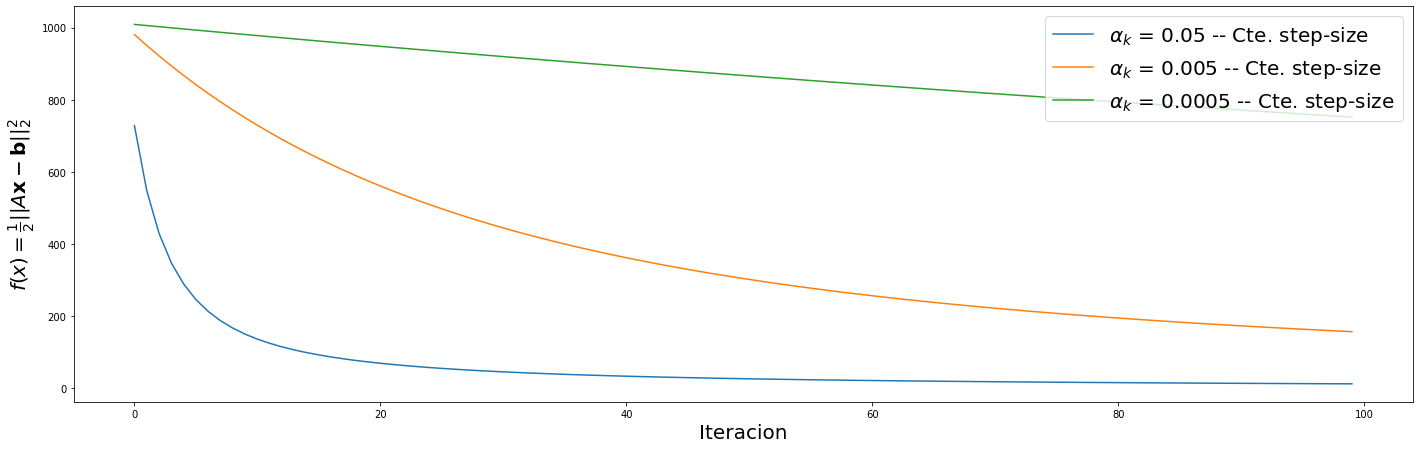

In [6]:


fig = PLT.figure(figsize=(24, 16))

ax1 = fig.add_subplot(2, 1, 1)

for k in range(len(ssCte)):
    PLT.plot(gdStats[k][:,0], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte[k], args.f2oDef.ss_list[args.f2oDef.ss_Cte]) )

PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2} \|\| A \mathbf{x} - \mathbf{b} \|\|_2^2$',fontsize=20)
PLT.xlabel('Iteracion',fontsize=20)

